# Prerequisites

In this section we import the relevant libraries, import and inspect the dataset and create a simple perceptual hashing function.

In [1]:
# Import libraries
import numpy as np
np.random.seed(101) # for reproducibility
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import os
from random import randint
import cv2
import pickle
import math
import time
import datetime
import json

from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.utils import to_categorical
from hexhamming import hamming_distance

/Users/willemdebeijer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Important parameters
num_classes = 10
img_cols = 28
img_rows = 28
depth = 1
batch_size = 64
classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

models_path = 'models'
results_path = 'results'

In [3]:
# Import dataset to RAM
fmnist = oml.datasets.get_dataset(40996)
X_orig, y_orig = fmnist.get_data(target=fmnist.default_target_attribute) # Original full dataset before any splitting

# Reshape data to 28x28 images and normalize to values in range 0-1
X_orig = np.reshape(X_orig, (len(X_orig), img_rows, img_cols, depth))
X_orig = X_orig.astype('float32') / 255

# Convert labels to categorical data
y_orig = to_categorical(y_orig)

In [4]:
# Function for creating our perceptual hash
def dhash(image, hash_size = 8):
    image = cv2.resize(image, dsize=(hash_size + 1, hash_size)) #image.convert('LA').resize((hash_size+1, hash_size), Image.ANTIALIAS)
    mat = image
    
    return ''.join(
        map(
            lambda x: hex(x)[2:].rjust(2,'0'),
            np.packbits(np.fliplr(np.diff(mat) < 0))
        )
    )
    

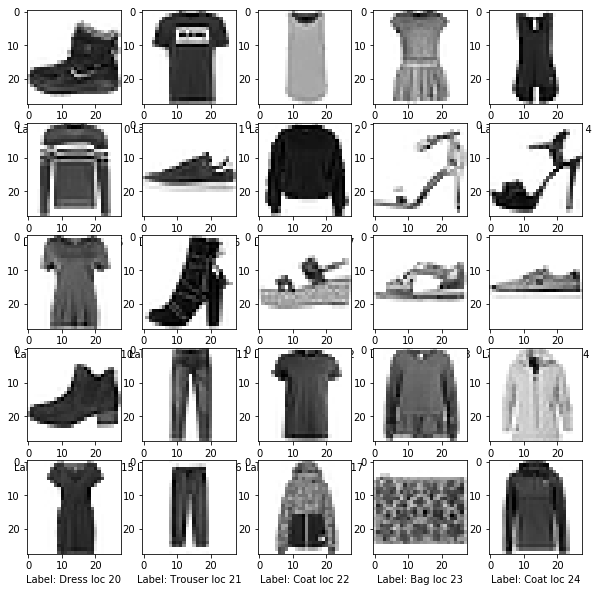

In [5]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        loc = i*5 + j
        axes[i, j].imshow(np.squeeze(X_orig[loc]), cmap=plt.cm.gray_r)
        label = classes[ int(np.where(y_orig[loc] == 1)[0]) ]
        axes[i, j].set_xlabel("Label: {} loc {}".format(label, loc))
plt.show()

In [6]:
# Sanity check for perceptual hashing function
print(hamming_distance(dhash(X_orig[16]), dhash(X_orig[21]))) # Two very similar pants should have a low hamming distance in dhash
print(hamming_distance(dhash(X_orig[16]), dhash(X_orig[23]))) # The same pants should have a higher distance with a bag

8
33


# Split dataset

Since we will be making many different datasets in this notebook, we want to have a separate validation set that can be used to score any algorithm created fairly. These samples will be held out from the start and cannot be used in any of the other datasets. All algorithms will therefore consider `X` and `y` to be the ground-dataset and split that dataset to their own training and testing set. Final comparison will be done on performance on the `X_valid` and `y_valid` validation dataset

In [7]:
# Split dataset in train and test split
X, X_valid, y, y_valid = train_test_split(X_orig, y_orig, train_size = 0.8, random_state = 7, shuffle=False)

/Users/willemdebeijer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Model class

Create a class that will hold our model. We can use this to make sure we're using the same model on different datasets, and to retain the history of the model while training.

In [8]:
class Model():
    
    def __init__(self, model_type):
        self.train_samples_seen = 0
        self.train_batches_seen = 0 # How often we have seen a train batch
        if model_type == 0:
            self.model = Model.standard_cnn()
        elif model_type == 1:
            self.model = Model.improved_cnn()
        self.history = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': [],
                       'st_acc': [], 'st_loss': [], 'dataset_size': [], 'test_split': []}
        """ 
        st_acc and st_loss use document standard that that is not included anywhere in model training
        This is done to keep consistency and comparability throughout all models
        """
        
    def train(self, X_train, y_train, epochs = 1000, verbose = 0, monitor = None):
        for e in range(epochs):
            test_split = 0.2
            epoch_result = self.model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, verbose = verbose, validation_split = test_split, shuffle = False)
            st_loss, st_acc = self.model.evaluate(X_valid, y_valid, batch_size = batch_size, verbose = verbose)
            
            # Append results from this epoch to history
            self.history['train_acc'].append(epoch_result.history['acc'][0])
            self.history['train_loss'].append(epoch_result.history['loss'][0])
            self.history['test_acc'].append(epoch_result.history['val_acc'][0])
            self.history['test_loss'].append(epoch_result.history['val_loss'][0])
            self.history['st_acc'].append(st_acc)
            self.history['st_loss'].append(st_loss)
            self.history['dataset_size'].append(y_train.shape[0])
            self.history['test_split'].append(test_split)
            
            self.train_samples_seen += y_train.shape[0]
            
            # Check if we are to stop training (only if this is not the first epoch)
            if e >= 1:
                if (monitor == 'val_loss' or (epochs == 1000 and monitor == None)) and self.history['test_loss'][-1] > self.history['test_loss'][-2]:
                    break
            
    
    def standard_cnn():
        model = models.Sequential()
        model.add(layers.Conv2D(16, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_rows, img_cols, 1)))
        model.add(layers.Flatten())
        model.add(layers.Dense(num_classes, activation = 'softmax'))
        model.compile(optimizer = 'Adam',
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
        return model
    
    def improved_cnn():
        model = models.Sequential()
        model.add(layers.Conv2D(32, kernel_size = (5, 5), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_rows, img_cols, 1)))
        model.add(layers.MaxPool2D())
        model.add(layers.Dropout(0.4))
        model.add(layers.Conv2D(64, kernel_size = (5, 5), strides = 1, padding = 'same', activation = 'relu'))
        model.add(layers.MaxPool2D())
        model.add(layers.Dropout(0.4))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(num_classes, activation = 'softmax'))
        model.compile(optimizer = 'Adam',
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
        return model

### Some standard convenience functions

In [9]:
def save_model(model_name, model):
    with open(os.path.join(models_path, model_name), 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name):
    with open(os.path.join(models_path, model_name), 'rb') as file:
        return pickle.load(file)

# Dataset creation

Here we will define our function that creates a dataset in one of the two following ways:
- Create a random dataset of a certain size
- Create a random seed dataset and then iteratively add the most different new samples in a batch approach

We will compare the performance of models that are trained on the different datasets. All models will be identical except for the data they are given.

In [18]:
seed_dataset_size = 100 # Number of instances seed dataset will have
selective_batch_size = 200 # Number of instances will be compared to existing dataset before picking next best options

def random_dataset(num_samples, X, y):
    """ Get random subset from data
    """
    size = num_samples / y.shape[0]
    X_subsample, X_unused, y_subsample, y_unused = train_test_split(X, y, train_size = size, random_state = 9)
    return X_subsample, y_subsample

def random_dataset_fraction(fraction, X, y):
    """ Get random dataset with fraction of size from original
    """
    return random_dataset(round(y.shape[0] * fraction), X, y)

def shuffle_in_unison(a, b):
    """ Shuffle two numpy arrays in the same way (e.g. data and labels)
    """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def selective_dataset(num_samples, X, y, take_most_different = True):
    """ Random seed dataset appended with the most different samples
    """
    # Shuffle dataset first to ensure we are not getting a very similar result each time
    shuffle_in_unison(X, y)
    
    seed_idx = np.random.randint(0, y.shape[0], size = seed_dataset_size)
    dataset = [] # Contains tuples with perceptual hash and index in dataset
    for index in seed_idx:
        dataset.append((dhash(X[index]), index))
        
    # Loop entire dataset and select best new images
    current_index = 0
    new_per_batch = math.ceil((num_samples - len(dataset)) / (y.shape[0] / selective_batch_size)) # Amount of new samples in each batch
    while len(dataset) < num_samples:
        # Do one batch
        batch_results = [] # (min_distance, index, hash)
        for index in range(current_index, current_index + selective_batch_size):
            new_hash = dhash(X[index])
            distances = [hamming_distance(x[0], new_hash) for x in dataset]
            min_distance = min(distances)
            batch_results.append((min_distance, index, new_hash))
        batch_results.sort(reverse=take_most_different)
        
        # Append best results to dataset
        for result in batch_results[:new_per_batch]:
            dataset.append((result[2], result[1]))
        
        current_index += selective_batch_size
    idx = [x[1] for x in dataset]
    idx.sort()
    X_new = np.take(X, idx, axis=0)
    y_new = np.take(y, idx, axis=0)
    return X_new, y_new

def selective_dataset_fraction(fraction, X, y, take_most_different = True):
    """ Get selective dataset with fraction of size from original
    """
    return selective_dataset(round(y.shape[0] * fraction), X, y, take_most_different = take_most_different)

# Random vs selected dataset

Try similar models on equally sized random and selective fractions of the ground dataset, and check how they compare in performance. Different models make their own train/test split on their dataset to determine when they have converged and should stop training, but final comparison for results is done on the same validation dataset.

### Expectations:
- In most cases, the selected dataset will perform beter than the random dataset
- A seed dataset that is too small will negatively influence our results since we will focus on outliers
- The selected dataset will outperform the random dataset the most in mid-size datasets, too small selected datasets will mostly focus on outliers and too large datasets will not profit from selection anymore
- The more complex model will benefit more from the selective dataset

In [11]:
dataset_fractions = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3]
folds = 5
results = []
model_type_expl = {0: 'Simple CNN 784 - [16C3] - 10 RELU', 
                   1: 'Improved CNN 784 - [32C5-P2-D0.4] - [64C5-P2-D0.4] - [128-D0.4] - 10 RELU'}


for fraction in dataset_fractions:
    for model_type in [0, 1]:
        ts = time.time()
        timestamp = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
        run = {'folds': folds, 'fraction': fraction, 'dataset_size': round(fraction * y.shape[0]), 
               'seed_size': seed_dataset_size, 'selective_batch_size': selective_batch_size,
               'batch_size': batch_size, 'startdate': timestamp, 'model': model_type, 
               'model_expl': model_type_expl[model_type],
              'results': {
                  'random': {'histories': []},
                  'selective': {'histories': []},
                  'selective_similar': {'histories': []}
              }}
        results.append(run)
        print("Run fraction: {} \tfolds: {} model: {}".format(fraction, folds, model_type))

        for i in range(folds):
            print("{}/{}".format(i + 1, folds))
            model_rand = Model(model_type)
            X_rand, y_rand = random_dataset_fraction(fraction, X, y)
            model_rand.train(X_rand, y_rand, verbose = 0)

            model_slct = Model(model_type)
            X_slct, y_slct = selective_dataset_fraction(fraction, X, y)
            model_slct.train(X_slct, y_slct, verbose = 0)
            
            model_slct_sim = Model(model_type)
            X_slct_sim, y_slct_sim = selective_dataset_fraction(fraction, X, y, take_most_different = False)
            model_slct_sim.train(X_slct_sim, y_slct_sim, verbose = 0)
            
            results[-1]['results']['random']['histories'].append(model_rand.history)
            results[-1]['results']['selective']['histories'].append(model_slct.history)
            results[-1]['results']['selective_similar']['histories'].append(model_slct_sim.history)
           
        ts = time.time()
        timestamp = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
        # Create a new datafile after each iteration to make sure we don't lose precious results
        outpath = results_path + '/' + timestamp + '.json'
        with open(outpath, 'w') as outfile:
            json.dump(results, outfile)

Run fraction: 0.005 	folds: 5 model: 0
1/5


/Users/willemdebeijer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2/5
3/5
4/5
5/5
Run fraction: 0.005 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.01 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.01 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.025 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.025 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.05 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.05 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.075 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.075 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.1 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.1 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.15 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.15 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.2 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.2 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.3 	folds: 5 model: 0
1/5
2/5
3/5
4/5
5/5
Run fraction: 0.3 	folds: 5 model: 1
1/5
2/5
3/5
4/5
5/5